In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data

The dataset contains 3636 training instances and 810 testing instances. Each timeseries corresponds to a measurement of engine noise captured by a vehicle sensor. For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a binary classification task. We will use the `Engine_TRAIN` file for training and the
`Engine_TEST` file for testing. In these files, the first column corresponds to the label.

In [2]:

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

x_train, y_train = readucr("Engine_TRAIN.tsv")
x_test, y_test = readucr("Engine_TEST.tsv")

## Visualize the data

Here we visualize one timeseries example for each of the two classes in the dataset.

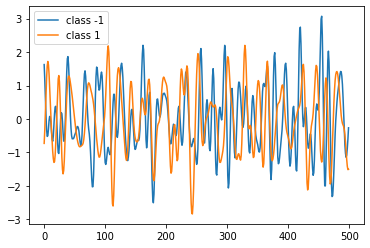

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries instances have a fixed length of 500 samples. The data is already z-normalized: each timeseries sample has a mean equal to zero and a standard deviation equal to one. This type of normalization is very common for timeseries classification problems. Note that the timeseries data used here are univariate, meaning we only have one channel per timeseries example. We will therefore transform the timeseries into a multivariate one with one channel using a simple reshaping via numpy. This will allow us to construct a model that is easily applicable to multivariate time series.

In [4]:
x_train.shape

(3636, 500)

In [5]:
x_test.shape

(810, 500)

In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(3636, 500, 1)

In [7]:
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(810, 500, 1)

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [8]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [9]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [10]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

This is where you define your model. A simple model is provided.

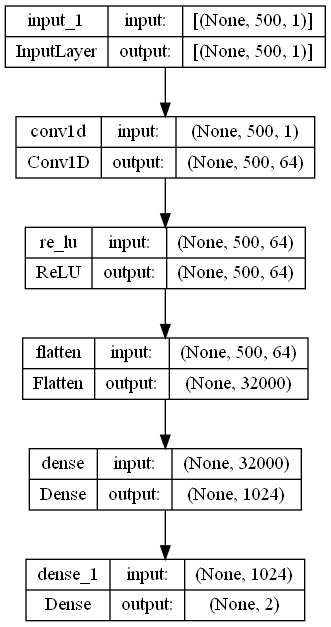

In [11]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.ReLU()(conv1)

    flat1 = keras.layers.Flatten()(conv1)
    
    dense1 = keras.layers.Dense(1024, activation="tanh")(flat1)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(dense1)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

This is where you specify and update hyperparameters for the training.

In [12]:
epochs = 100
batch_size = 16

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    )
]
model.compile(
    optimizer="sgd",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
182/182 [==============================] - 6s 6ms/step - loss: 0.7472 - sparse_categorical_accuracy: 0.5076 - val_loss: 0.6975 - val_sparse_categorical_accuracy: 0.5426
Epoch 2/100
182/182 [==============================] - 1s 4ms/step - loss: 0.6768 - sparse_categorical_accuracy: 0.5757 - val_loss: 0.6964 - val_sparse_categorical_accuracy: 0.5371
Epoch 3/100
182/182 [==============================] - 1s 3ms/step - loss: 0.6538 - sparse_categorical_accuracy: 0.6025 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.5288
Epoch 4/100
182/182 [==============================] - 1s 4ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.6214 - val_loss: 0.6752 - val_sparse_categorical_accuracy: 0.5824
Epoch 5/100
182/182 [==============================] - 1s 3ms/step - loss: 0.6357 - sparse_categorical_accuracy: 0.6355 - val_loss: 0.7018 - val_sparse_categorical_accuracy: 0.5247
Epoch 6/100
182/182 [==============================] - 1s 4ms/step - loss: 0.6256 - sparse_cate

182/182 [==============================] - 1s 3ms/step - loss: 0.4983 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.7759 - val_sparse_categorical_accuracy: 0.5453
Epoch 47/100
182/182 [==============================] - 1s 3ms/step - loss: 0.5000 - sparse_categorical_accuracy: 0.7583 - val_loss: 0.6965 - val_sparse_categorical_accuracy: 0.5852
Epoch 48/100
182/182 [==============================] - 1s 3ms/step - loss: 0.4828 - sparse_categorical_accuracy: 0.7675 - val_loss: 0.7721 - val_sparse_categorical_accuracy: 0.5632
Epoch 49/100
182/182 [==============================] - 1s 3ms/step - loss: 0.4755 - sparse_categorical_accuracy: 0.7803 - val_loss: 0.7239 - val_sparse_categorical_accuracy: 0.6332
Epoch 50/100
182/182 [==============================] - 1s 3ms/step - loss: 0.4972 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.6195
Epoch 51/100
182/182 [==============================] - 1s 3ms/step - loss: 0.4679 - sparse_categorical

182/182 [==============================] - 1s 3ms/step - loss: 0.2707 - sparse_categorical_accuracy: 0.8889 - val_loss: 1.5796 - val_sparse_categorical_accuracy: 0.5591
Epoch 92/100
182/182 [==============================] - 1s 4ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.8882 - val_loss: 0.6030 - val_sparse_categorical_accuracy: 0.7280
Epoch 93/100
182/182 [==============================] - 1s 3ms/step - loss: 0.3766 - sparse_categorical_accuracy: 0.8501 - val_loss: 0.6786 - val_sparse_categorical_accuracy: 0.6717
Epoch 94/100
182/182 [==============================] - 1s 3ms/step - loss: 0.3230 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.7941 - val_sparse_categorical_accuracy: 0.6346
Epoch 95/100
182/182 [==============================] - 1s 3ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.6138 - val_sparse_categorical_accuracy: 0.7170
Epoch 96/100
182/182 [==============================] - 1s 3ms/step - loss: 0.3841 - sparse_categorical

## Evaluate model on test data

In [13]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

26/26 [==============================] - 0s 2ms/step - loss: 0.8956 - sparse_categorical_accuracy: 0.5593
Test accuracy 0.5592592358589172
Test loss 0.8955643773078918


## Plot the model's training and validation loss

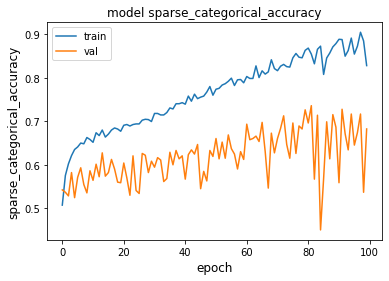

In [14]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()